<h1 align="center">Projeto Final 2019</h1>

<h3 align="center">Gabriel Lima Novais</h3>

<p align="center"><b>Objetivo:</b> Neste projeto cada aluno deve eleger um corpus de documentos de tamanho médio (pelo menos milhares de documentos). Todas as tarefas a seguir serao realizadas sobre este corpus.</p>

<p align="center"><b>Corpus utililzado:</b> Base de artigos da Wikipedia (3.2GB). Para realizar o entendimento inicial de cada exercício (e até mesmo para a implementação), a estratégia utilizada por mim foi a de considerar um corpus de teste com número extramamente reduzido de artigos (10 artigos) e depois dessa etapa pegar a base de dados composta por 200.000 artigos.</p>

#### Importando pacotes:

In [877]:
import numpy as np
import pandas as pd
import os
import re
import whoosh
import nltk
import string
import matplotlib.pyplot as plt
import enchant
import seaborn as sns
import shutil
import gensim
import logging
#------------------------------------------------------------------------------------
from IPython.display import display, Markdown, Latex
from collections import defaultdict,Counter,OrderedDict
from math import log
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from string import punctuation
from tqdm import tqdm
#____________________________________________________________________________________
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,wrappers
#____________________________________________________________________________________
from nltk.corpus import machado, mac_morpho,stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer,PortugueseStemmer
#____________________________________________________________________________________
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
#____________________________________________________________________________________
from whoosh import sorting
from whoosh.index import create_in, open_dir
from whoosh.fields import *
from whoosh import qparser
from whoosh.qparser import QueryParser

#### Configurações iniciais:

In [2]:
#O corpus escolhido está em Inglês, então as devidas configurações são:
nltk.download('stopwords')
swu = stopwords.words('english')+ list(string.punctuation)
stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


#### Preparando o Corpus

In [3]:
def data(file,nr,sample):

    #Importando os dados da Wikipedia em formato csv:
    df = pd.read_table(file, sep=",", nrows=nr,header=None)

    #Tratando a base de dados:
    df.columns = ['id','content']
    df.id = df.id.apply(lambda x: int(x[10:]))

    #Retirando uma amostra pequena para realizar as questões da lista sem demorar muito...
    #OBS: Toda vez que rodar essa linha abixo o Corpus vai mudar e assim as respostas devem mudar!!!
    corpus =  df.sample(n=sample)
    corpus = corpus.reset_index().drop(['index'], axis=1)

    #Visualizando aas primeiras linhas do Corpus:
    return corpus

In [351]:
corpus = data("corpusEx.csv",10000,10)
corpus.head()

,id,content
0,13340545,Event of default Event of default is a term ...
1,1199424,Hotter than July Hotter than July is the nin...
2,2092024,HypoVereinsbank UniCredit Bank Aktiengesells...
3,755408,Committee to Protect Journalists The Committ...
4,1190581,Critical opalescence Critical opalescence is...


In [868]:
corpusteste = corpus.copy()
corpusteste

,id,content
0,13340545,Event of default Event of default is a term ...
1,1199424,Hotter than July Hotter than July is the nin...
2,2092024,HypoVereinsbank UniCredit Bank Aktiengesells...
3,755408,Committee to Protect Journalists The Committ...
4,1190581,Critical opalescence Critical opalescence is...
5,291161,Communications of the ACM Communications of ...
6,5670762,"Alabama Thunderpussy Alabama Thunderpussy, o..."
7,982464,12 Stones 12 Stones is an American Christian...
8,230594,Bratz Bratz is an American line of fashion d...
9,34510185,Monster Bug Wars Monster Bug Wars is a natur...


### (Questão 1) Indexação

<ul>
<li>Utilizando o Whoosh, indexar o seu corpus e implementar uma funçao que apresente para os top 10 documentos da resposta a uma consulta, trechos dos documentos contendo os termos da consulta.</li>
<li>Contruir uma funçao de busca que aceite consultas frasais e facetaçao dos resultados.</li>
</ul>

In [376]:
 def whooshSearcher(sentence, corpus):
    #______________________________________________________________________________________________________   
    #Definindo variáveis auxiliares
    schema = Schema(cont=TEXT(phrase=True, stored=True))
    
    #Criando o indexidr:
    if os.path.exists('indexdir'):
        shutil.rmtree('/home/novais/Desktop/Mestrado/3_trim_2019/SRI/Trabalho Final/indexdir')
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    else:
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    #______________________________________________________________________________________________________
    
    aux=[]
    positions=[]


    query = QueryParser("cont", schema=ix.schema,group=qparser.OrGroup).parse(sentence)
    facets = sorting.Facets()
    facets.add_field("cont")
    facets.add_field("cont", allow_overlap=True)
    answer = ix.searcher().search(query,limit=10, groupedby=facets)
    for k in answer:
        positions.append(corpus[corpus.isin([k.values()[0]])].index[0])
    for hit in answer:
        aux.append(re.split("\.\.\.", hit.highlights("cont")))
    print("Resultados em ordem de similaridade:")
    print(" ")
    for j in range(len(aux)):
        print("Trechos do resultado "+str(j+1)+", linha "+str(positions[j])+" do Corpus")
        for i in range(len(aux[j])):
            display(Markdown("Trecho "+str(i)+":  [...] "+aux[j][i]+" [...]"))
        print(" ")


    return positions

In [611]:
whooshSearcher("July Hotter than",corpusteste.content)

Resultados em ordem de similaridade:
 
Trechos do resultado 1, linha 1 do Corpus


Trecho 0:  [...] <b class="match term0">Hotter</b> <b class="match term1">than</b> <b class="match term2">July</b>  <b class="match term0">Hotter</b> <b class="match term1">than</b> <b class="match term2">July</b> is the nineteenth album [...]

Trecho 1:  [...] four top ten singles. "<b class="match term0">Hotter</b> <b class="match term1">than</b> <b class="match term2">July</b>" was nominated for Favorite [...]

Trecho 2:  [...] was to be titled "<b class="match term0">Hotter</b> <b class="match term1">than</b> <b class="match term2">July</b>". Inspired by his love [...]

 
Trechos do resultado 2, linha 3 do Corpus


Trecho 0:  [...] are typically lower <b class="match term1">than</b> similar ongoing counts [...]

Trecho 1:  [...] network of more <b class="match term1">than</b> seventy non-governmental [...]

Trecho 2:  [...] 1998 to 2006. Since <b class="match term2">July</b> 2006, journalist Joel [...]

 
Trechos do resultado 3, linha 9 do Corpus


Trecho 0:  [...] less sound effects <b class="match term1">than</b> season one. Further [...]

Trecho 1:  [...] episode released in <b class="match term2">July</b>, 2012. This episode included [...]

 
Trechos do resultado 4, linha 8 do Corpus


Trecho 0:  [...] Bratz Babyz. Smaller <b class="match term1">than</b> regular Bratz Babyz [...]

Trecho 1:  [...] and thus, shorter <b class="match term1">than</b> the regular Bratz. Bratz [...]

Trecho 2:  [...] competition.” On <b class="match term2">July</b> 22, 2010, the Ninth Circuit [...]

 
Trechos do resultado 5, linha 2 do Corpus


Trecho 0:  [...] and has more <b class="match term1">than</b> 8.5 million clients [...]

Trecho 1:  [...] on 28 November. More <b class="match term1">than</b> 60 prosecutors, tax [...]

 
Trechos do resultado 6, linha 6 do Corpus


Trecho 0:  [...] being slated for <b class="match term2">July</b> 25, 2006. Erik Larson [...]

 
Trechos do resultado 7, linha 7 do Corpus


Trecho 0:  [...] They have sold more <b class="match term1">than</b> 2 million records. History [...]

[1, 3, 9, 8, 2, 6, 7]

### (Questão 2) Modelagem de Assuntos
<ul>
    <li>Usando a biblioteca Gensim, treine um modelo LSI e LDA para o seu corpus propondo uma metodologia para otimizaçao do numero de assuntos</li>
    <li>Construa Uma matriz de similaridade entre os documentos do corpus a partir dos pesos</li>
</ul>

##### Algumas definições:
<b>TF-IDF : </b>In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

<b>LSA (LSI) : </b> Latent semantic analysis (LSA) is a technique in natural language processing, in particular distributional semantics, of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms. LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis). A matrix containing word counts per document (rows represent unique words and columns represent each document) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns. Documents are then compared by taking the cosine of the angle between the two vectors (or the dot product between the normalizations of the two vectors) formed by any two columns. Values close to 1 represent very similar documents while values close to 0 represent very dissimilar documents.

<b>Interpretação:</b> Para o TF-IDF, a função abaixo retorna o "peso" que cada palavra do dicionário construído a partir de cada texto do Corpus (palavras únicas) possui para aquele texto. Já para o LSI e LDA temos que é retornado para cada texto do Corpus um vetor que fornece o quanto cada tema está relacionado com aquele texto. Além disso podemos verificar também como cada tema é construído, isto é, quais palavras do dicionário construído anteriormente para elaborar o TF-IDF são as mais importantes para aquele tema. Abaixo veja as explicações ilistradas:  

In [894]:
def LS(txt,nthemes):
    
    try:
        os.remove("corpusWiki.mm")
        os.remove("corpusWiki.mm.index")
        os.remove("vocabulario.dict")
    except:
        print(" ")
    
    #________________________________________________________________________________________________________
    #Incializando vetores:
    txtClean = []
    c = Counter([])
    
    #Loop:
    for texto in txt:
        aux = [stemmer.stem(token.strip(punctuation).lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
        c.update(aux)
        txtClean.append(aux)
    txtClean = [[token for token in t if c[token]>1] for t in txtClean]
    
    #________________________________________________________________________________________________________

    #Gerando dicionário:
    dicionario = corpora.Dictionary(txtClean)
    dicionario.save('vocabulario.dict')
    
    #________________________________________________________________________________________________________
    #Gerando as frequências:
    corpus = [dicionario.doc2bow(d) for d in txtClean]
    corpora.MmCorpus.serialize('corpusWiki.mm', corpus)
    
    #________________________________________________________________________________________________________
    #TF-IDF:
    mod_tfidf = models.TfidfModel(corpus)
    corpus_tfidf = mod_tfidf[corpus]
    #LSI:
    mod_lsi = models.LsiModel(corpus_tfidf, id2word=dicionario, num_topics=nthemes)
    corpus_lsi = mod_lsi[corpus_tfidf]
    #LDA:
    mod_lda = models.LdaModel(corpus_tfidf, id2word=dicionario, num_topics=nthemes)
    corpus_lda = mod_lda[corpus_tfidf]
    #________________________________________________________________________________________________________
    # Compute Perplexity
    perplexity = mod_lda.log_perplexity(corpus)
    #print('\nPerplexity: ', mod_lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=mod_lda, texts=txtClean, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    #print('\nCoherence Score: ', coherence_lda)
        
    return [mod_lsi,mod_lda,corpus_lsi,corpus_lda,corpus_tfidf,perplexity,coherence_lda,dicionario,txtClean]

<b>Caso para exemplificar o funcionamento: </b>O texto txt[0] abaixo retirado do Corpus de teste é relacionado a Economia/Finanças e resumidamente fala sobre default, ou seja, calote

In [653]:
txt = corpusteste.content
txt[0]

' Event of default  Event of default is a term used in commercial loan documentation. It refers to the occurrence of an event which allows the lender to demand repayment of the loan in advance of its normal due date (also known as "accelerating" the loan). In a revolving credit facility, the occurrence of an event of default normally also allows the lender to cancel any obligations to make further loan advances. There are two types of event of default: '

O resultado do TF-IDF para este texto é tal que as palavras, cujos indices estão em primeiro lugar nas tuplas abaixo, possuem um nível de importância determinado pelo segundo número da tupla:

In [670]:
number_of_topics = 10
model = LS(txt,number_of_topics)

In [658]:
model[4][0]

[(0, 0.005819998754287493),
 (1, 0.13301226133193222),
 (2, 0.17780715265080874),
 (3, 0.011639997508574987),
 (4, 0.08890357632540437),
 (5, 0.08890357632540437),
 (6, 0.508769050310579),
 (7, 0.08890357632540437),
 (8, 0.06650613066596611),
 (9, 0.4445178816270218),
 (10, 0.01970233076829846),
 (11, 0.01970233076829846),
 (12, 0.06650613066596611),
 (13, 0.2543845251552895),
 (14, 0.508769050310579),
 (15, 0.050614890073164026),
 (16, 0.17780715265080874),
 (17, 0.2543845251552895),
 (18, 0.08890357632540437),
 (19, 0.08890357632540437),
 (20, 0.08890357632540437),
 (21, 0.08890357632540437),
 (22, 0.02821744441372576),
 (23, 0.06650613066596611),
 (24, 0.03828868625224035)]

Agora, os tópicos selecionados pelo modelo de LSI e LDA e determinados (cada um) por uma quantidade de 4 palavras estão descritos abaixo pelo seu índicie especificado no primeiro termo da tupla:

In [659]:
#LSI:
model[0].print_topics(num_topics=10, num_words=4)

[(0, '-0.225*"album" + -0.224*"record" + -0.223*"band" + -0.197*"song"'),
 (1, '0.322*"journalist" + 0.293*"cacm" + 0.293*"acm" + 0.246*"publish"'),
 (2, '0.308*"loan" + 0.308*"default" + 0.286*"event" + 0.256*"bug"'),
 (3, '-0.367*"opalesc" + -0.306*"fluctuat" + 0.244*"bratz" + -0.201*"bank"'),
 (4, '-0.373*"bratz" + 0.271*"default" + 0.271*"loan" + 0.229*"event"'),
 (5, '0.290*"opalesc" + -0.251*"loan" + -0.251*"default" + -0.250*"bank"'),
 (6, '0.569*"bratz" + -0.298*"bug" + -0.271*"vs" + 0.214*"doll"'),
 (7, '-0.301*"wonder" + 0.210*"alabama" + -0.172*"photo" + 0.168*"johnni"'),
 (8, '-0.409*"journalist" + 0.349*"acm" + 0.349*"cacm" + -0.286*"organ"'),
 (9, '0.202*"wwe" + 0.202*"stone" + -0.192*"wonder" + 0.188*"song"')]

In [660]:
#LDA:
model[1].print_topics(num_topics=10, num_words=4)

[(0, '0.001*"bratz" + 0.001*"doll" + 0.001*"mga" + 0.001*"mattel"'),
 (1, '0.001*"loan" + 0.001*"event" + 0.001*"default" + 0.001*"bratz"'),
 (2, '0.001*"event" + 0.001*"default" + 0.001*"loan" + 0.001*"acm"'),
 (3, '0.001*"loan" + 0.001*"default" + 0.001*"opalesc" + 0.001*"acm"'),
 (4, '0.001*"bratz" + 0.001*"loan" + 0.001*"default" + 0.001*"acm"'),
 (5,
  '0.008*"journalist" + 0.007*"opalesc" + 0.006*"fluctuat" + 0.006*"organ"'),
 (6, '0.006*"bank" + 0.005*"wonder" + 0.004*"charg" + 0.004*"hvb"'),
 (7, '0.008*"loan" + 0.008*"default" + 0.007*"event" + 0.005*"lender"'),
 (8, '0.010*"bratz" + 0.006*"acm" + 0.006*"cacm" + 0.005*"alabama"'),
 (9, '0.006*"bug" + 0.006*"vs" + 0.004*"song" + 0.004*"sound"')]

Então, como já sabemos como estão descritos cada um dos tópicos acima, podemos interpretar quem eles são. Por exemplo, o tópico 5 de LSI demonstra estar muito relacionado com Economia pois envolve as palavras "bank","loan" e "default" com significativos coeficientes de importância. Por outro lado, para o modelo LDA temos que o tópico 5 também está relacionado com essa temática, pois é composto pelas seguintes palavras:"default" e "loan". Desta maneira, seria interessante que o resultado do modelo para o primeiro texto, que verificamos anteriormente, aponte uma grande relação destes tópico com o texto. Para verificar tal fato vamos ver o resultado:

In [661]:
#LSI:
model[2][0]

[(0, -0.06999607605107416),
 (1, 0.11728457178068975),
 (2, 0.6180707607023815),
 (3, -0.046382879979242043),
 (4, 0.5280192131389174),
 (5, -0.4850898061393002),
 (6, 0.27845882828293617),
 (7, -0.03209682335195001),
 (8, -0.066872346959),
 (9, 0.004918983571883014)]

In [662]:
#LDA:
model[3][0]

[(0, 0.022505669),
 (1, 0.022505669),
 (2, 0.022505669),
 (3, 0.022505669),
 (4, 0.022505669),
 (5, 0.022505866),
 (6, 0.022505984),
 (7, 0.7974464),
 (8, 0.02250598),
 (9, 0.022507375)]

Verificamos que:
<ul>
    <li>LSI: 2,4,5 possuem valores absolutos altos.</li>
    <li>LDA: 5 possui valor maior.</li>
</ul>

E verificando cada um deles vemos que de fato o tema está bem similar ao que é descrito no texto procurado. Precisamos agora saber qual a quantidade ideal de temas a serem feitos, e para isso devemos olhar para o modelo e verificar algumas métricas. Idealmente quanto menor a "perplexity" e maior o "Coeherence score" melhor é o modelo. Vejamos então para o modelo acima como estão essas métricas:

In [766]:
number_of_topics = 10
modelo = LS(txt,number_of_topics)
print('\nPerplexity: ', model[5])
print('\nCoeherence Score: ', model[6])


Perplexity:  -11.184841965824676

Coeherence Score:  0.5226788256057822


In [834]:
def coherence_values(txt, limit, start, step):
    coherence_values = []
    for num_topics in range(start, limit, step):
        modelo = LS(txt,num_topics)
        coherence_values.append(modelo[6])

    return coherence_values

def perplexity_values(txt, limit, start, step):
    perplexity_values = []
    for num_topics in range(start, limit, step):
        modelo = LS(txt,num_topics)
        perplexity_values.append(modelo[5])

    return perplexity_values

start = 2
step = 3
limit=15

coherence_values = coherence_values(txt,limit,start, step)
perplexity_values = perplexity_values(txt,limit,start, step)
perplexity_values_abs = [i/np.sum(perplexity_values) for i in perplexity_values]

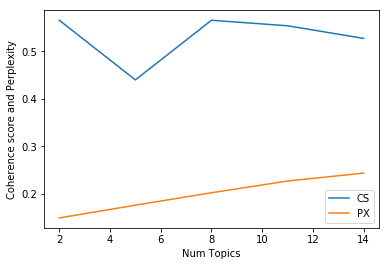

In [876]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.plot(x, perplexity_values_abs)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score and Perplexity")
plt.legend(['CS','PX'])
plt.show()

Veja que a quantidade de tópicos ótima nos parece ser a de valor 8, além disso conforme o tamanho do corpus vai aumentando temos que o limite máximo de assuntos intutitivamente deve ser o tamanho do própriro corpus. Então, dado o tamanho do corpus encontramos o que possui o maior "CS". Outro ponto importante seria analisar o "perplexity", cujo valor quanto menor melhor (no caso do gráfico seria o maior, devido a normalização e o valor absoluto).

In [815]:
modelo[0].print_topics(num_topics=8, num_words=4)

[(0, '0.225*"album" + 0.224*"record" + 0.223*"band" + 0.197*"song"'),
 (1, '-0.322*"journalist" + -0.293*"cacm" + -0.293*"acm" + -0.246*"publish"'),
 (2, '-0.308*"default" + -0.308*"loan" + -0.286*"event" + -0.256*"bug"'),
 (3, '0.367*"opalesc" + 0.306*"fluctuat" + -0.244*"bratz" + 0.201*"bank"'),
 (4, '0.373*"bratz" + -0.271*"loan" + -0.271*"default" + -0.229*"event"'),
 (5, '-0.290*"opalesc" + 0.251*"default" + 0.251*"loan" + 0.250*"bank"'),
 (6, '-0.569*"bratz" + 0.298*"bug" + 0.271*"vs" + -0.214*"doll"'),
 (7, '-0.301*"wonder" + 0.210*"alabama" + -0.172*"photo" + 0.168*"johnni"')]

In [816]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(modelo[1], modelo[3],modelo[7])
vis

/home/novais/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.000180 -0.000321       1        1  46.039547
2      0.002361 -0.001502       2        1  11.216197
0     -0.007852 -0.008024       3        1  11.184631
4     -0.000781 -0.000754       4        1   6.313434
3     -0.005392  0.010787       5        1   6.312902
6      0.011223 -0.000162       6        1   6.312178
5      0.000131 -0.000012       7        1   6.310553
1      0.000131 -0.000012       8        1   6.310553, topic_info=     Category     Freq          Term     Total  loglift  logprob
term                                                            
575   Default  0.00000         bratz  0.000000  30.0000  30.0000
384   Default  0.00000    journalist  0.000000  29.0000  29.0000
415   Default  0.00000       opalesc  0.000000  28.0000  28.0000
406   Default  0.00000      fluctuat  0.000000  27.0000  27.0000
293   Default  0.00000          bank  0.000000  26.0000  26.0000
266   Default  0.00000        wonder  0.000000  25.0000  25.0000
424   Default  0.00000           acm  0.000000  24.0000  24.0000
425   Default  0.00000          cacm  0.000000  23.0000  23.0000
388   Default  0.00000         organ  0.000000  22.0000  22.0000
447   Default  0.00000       alabama  0.000000  21.0000  21.0000
731   Default  0.00000           bug  0.000000  20.0000  20.0000
381   Default  0.00000       freedom  0.000000  19.0000  19.0000
389   Default  0.00000         press  0.000000  18.0000  18.0000
750   Default  0.00000            vs  0.000000  17.0000  17.0000
62    Default  0.00000          band  0.000000  16.0000  16.0000
298   Default  0.00000         charg  0.000000  15.0000  15.0000
316   Default  0.00000           hvb  0.000000  14.0000  14.0000
328   Default  0.00000       mollath  0.000000  13.0000  13.0000
461   Default  0.00000        johnni  0.000000  12.0000  12.0000
454   Default  0.00000           cox  0.000000  11.0000  11.0000
476   Default  0.00000  thunderpussi  0.000000  10.0000  10.0000
457   Default  0.00000          erik  0.000000   9.0000   9.0000
391   Default  0.00000       publish  0.000000   8.0000   8.0000
413   Default  0.00000        liquid  0.000000   7.0000   7.0000
416   Default  0.00000    phenomenon  0.000000   6.0000   6.0000
41    Default  0.00000         album  0.000000   5.0000   5.0000
204   Default  0.00000        record  0.000000   4.0000   4.0000
357   Default  0.00000        annual  0.000000   3.0000   3.0000
370   Default  0.00000      director  0.000000   2.0000   2.0000
84    Default  0.00000        critic  0.000000   1.0000   1.0000
...       ...      ...           ...       ...      ...      ...
6      Topic8  0.00084       default  0.036458  -1.0070  -6.6212
406    Topic8  0.00084      fluctuat  0.014931  -0.1142  -6.6212
425    Topic8  0.00084          cacm  0.017768  -0.2882  -6.6212
9      Topic8  0.00084         event  0.033721  -0.9289  -6.6212
424    Topic8  0.00084           acm  0.017768  -0.2882  -6.6212
14     Topic8  0.00084          loan  0.036457  -1.0070  -6.6212
391    Topic8  0.00084       publish  0.016426  -0.2097  -6.6212
731    Topic8  0.00084           bug  0.017119  -0.2511  -6.6212
575    Topic8  0.00084         bratz  0.020891  -0.4502  -6.6213
384    Topic8  0.00084    journalist  0.015659  -0.1619  -6.6213
13     Topic8  0.00084        lender  0.024431  -0.6068  -6.6213
415    Topic8  0.00084       opalesc  0.015436  -0.1476  -6.6213
16     Topic8  0.00084        normal  0.021164  -0.4633  -6.6213
293    Topic8  0.00084          bank  0.014881  -0.1110  -6.6213
388    Topic8  0.00084         organ  0.014730  -0.1008  -6.6213
84     Topic8  0.00084        critic  0.014206  -0.0647  -6.6213
17     Topic8  0.00084        occurr  0.024430  -0.6068  -6.6213
41     Topic8  0.00084         album  0.016239  -0.1984  -6.6213
750    Topic8  0.00084            vs  0.016691  -0.2258  -6.6213
328    Topic8  0.00084       mollath 

Finalmente fazendo a matriz de similaridade de acordo com o pacote Gensim, obtemos que:

In [872]:
fonte = similarities.MatrixSimilarity(modelo[3])
fonte = list(fonte)
head = list(corpusteste.id)
fonte.insert(0,np.array(head))


pd.DataFrame(fonte[1:],index=np.array(head),columns=np.array(head))

,13340545,1199424,2092024,755408,1190581,291161,5670762,982464,230594,34510185
13340545,1.000000,0.047941,0.055329,0.059935,0.063017,0.065685,0.056675,0.050433,0.054367,0.054821
1199424,0.047941,1.000000,0.029061,0.033144,0.035878,0.038239,0.030262,0.024734,0.028211,0.028595
2092024,0.055329,0.029061,1.000000,0.999948,0.042872,0.045311,0.037062,0.031339,0.034958,0.035332
755408,0.059935,0.033144,0.999948,1.000000,0.047231,0.049739,0.041305,0.035468,0.039179,0.039542
1190581,0.063017,0.035878,0.042872,0.047231,1.000000,0.052661,0.999902,0.038226,0.041968,0.042359
291161,0.065685,0.038239,0.045311,0.049739,0.052661,1.000000,0.046596,0.040616,0.999688,0.044794
5670762,0.056675,0.030262,0.037062,0.041305,0.999902,0.046596,1.000000,0.032555,0.036187,0.036577
982464,0.050433,0.024734,0.031339,0.035468,0.038226,0.040616,0.032555,1.000000,0.030518,0.999954
230594,0.054367,0.028211,0.034958,0.039179,0.041968,0.999688,0.036187,0.030518,1.000000,0.034498
34510185,0.054821,0.028595,0.035332,0.039542,0.042359,0.044794,0.036577,0.999954,0.034498,1.000000


### (Questão 3) Word2vec

<ul>
    <li>Ainda usando a biblioteca Gensim, construa uma representaçao vetorial semântica (Word2vec) do seu corpus de escolha. Podem seguir este tutorial <a href="https://rare-technologies.com/word2vec-tutorial/">https://rare-technologies.com/word2vec-tutorial/</a></li>
    <li>Construa uma representaçao similar usando <a href="https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText">FastText</a>. Veja este <a href="https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb">Tutorial</a></li>
</ul>

Vamos inicialmente utilizar o exemplo do exercício anterior para analisar a interpretação do Word2vec.

In [882]:
txt

0     Event of default  Event of default is a term ...
1     Hotter than July  Hotter than July is the nin...
2     HypoVereinsbank  UniCredit Bank Aktiengesells...
3     Committee to Protect Journalists  The Committ...
4     Critical opalescence  Critical opalescence is...
5     Communications of the ACM  Communications of ...
6     Alabama Thunderpussy  Alabama Thunderpussy, o...
7     12 Stones  12 Stones is an American Christian...
8     Bratz  Bratz is an American line of fashion d...
9     Monster Bug Wars  Monster Bug Wars is a natur...
Name: content, dtype: object

In [902]:
def W2V(txt):
    
    try:
        os.remove("corpusWikiW2V.mm")
        os.remove("corpusWikiW2V.mm.index")
        os.remove("vocabularioW2V.dict")
    except:
        print(" ")
    
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    #________________________________________________________________________________________________________
    #Incializando vetores:
    txtClean = []
    c = Counter([])
    
    #Loop:
    for texto in txt:
        aux = [stemmer.stem(token.strip(punctuation).lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
        c.update(aux)
        txtClean.append(aux)
    txtClean = [[token for token in t if c[token]>1] for t in txtClean]
    
    #________________________________________________________________________________________________________

    #Gerando dicionário:
    dicionario = corpora.Dictionary(txtClean)
    dicionario.save('vocabularioW2V.dict')
    
    #________________________________________________________________________________________________________
    #Gerando as frequências:
    corpus = [dicionario.doc2bow(d) for d in txtClean]
    corpora.MmCorpus.serialize('corpusWikiW2V.mm', corpus)
    
    #________________________________________________________________________________________________________
    #TF-IDF:
    mod_tfidf = models.TfidfModel(corpus)
    corpus_tfidf = mod_tfidf[corpus]
    #W2V:
    mod_w2v = models.Word2Vec(txtClean, min_count=1)
#     corpus_w2v = mod_w2v[txtClean]
          
#     return [mod_w2v,corpus_w2v,dicionario]
    return mod_w2v

In [913]:
vetor = W2V(txt)
print(vetor)

Word2Vec(vocab=751, size=100, alpha=0.025)


In [919]:
vetor.n_similarity(["bank","loan"], ["default"])

/home/novais/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  """Entry point for launching an IPython kernel.


0.03702873